<a href="https://colab.research.google.com/github/bryanathll/finetuning-w11wo-indonesian-roberta-base-sentiment-classifier/blob/main/FinetuningIndoRoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emoji
!pip install datasets
# !pip install --upgrade numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 23.1 MB/s eta 0:00:00


### import package

In [ ]:
import pandas as pd
import re
import emoji
import numpy as np
import torch
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import torch.nn as nn

In [ ]:
df = pd.read_csv('INA_TweetsPPKM_Labeled_Pure.csv')

print(df.columns)

Index(['Date', 'User', 'Tweet', 'sentiment'], dtype='object')


In [ ]:
# memilih hanya kolom yang akan digunakan

df = df[['Tweet', 'sentiment']]

In [ ]:
# cleaning dataset dari emoji, simbol, link dan spasi berl

def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)  # hapus link
    text = re.sub(r'@\w+', '', text)     # hapus @username
    text = re.sub(r'#(\w+)', r'\1', text)  # ubah #bagus jadi bagus
    text = re.sub(r'[^\w\s]', '', text)  # hapus simbol (tanda baca dll)
    text = re.sub(r'\s+', ' ', text).strip()  # hapus spasi berlebih
    return text.lower()

df["Tweet"] = df["Tweet"].apply(clean_tweet)

print(df.head())

                        Date           User  \
0  2022-03-31 14:32:04+00:00  pikobar_jabar   
1  2022-03-31 09:26:00+00:00     inewsdotid   
2  2022-03-31 05:02:34+00:00      vdvc_talk   
3  2022-03-30 14:23:10+00:00  pikobar_jabar   
4  2022-03-30 11:28:57+00:00      tvOneNews   

                                               Tweet  sentiment  
0  ketahui informasi pembagian ppkm di wilayah ja...          1  
1  tempat ibadah di wilayah ppkm level 1 boleh be...          1  
2  juru bicara satgas covid19 wiku adisasmito men...          1  
3  ketahui informasi pembagian ppkm di wilayah ja...          1  
4  kementerian agama menerbitkan surat edaran nom...          1  


In [ ]:
# mengganti nama kolom menjadi text dan label

df = df.rename(columns={'Tweet': 'text', 'sentiment': 'label'})

In [ ]:
print(df['label'].value_counts())

label
1    17706
2     3980
0     1958
Name: count, dtype: int64


In [ ]:
# df = df.to_csv('dataset.csv', index=False)

In [ ]:
df = df.drop_duplicates(subset="text")
df = df.dropna(subset=["text", "label"])

In [ ]:
print(df['label'].value_counts())

label
1    15579
2     3878
0     1885
Name: count, dtype: int64


In [ ]:
df = df.to_csv('dataset.csv', index=False)

### Menciptakan bobot yang akan "mengkompensasi" ketimpangan jumlah label.

In [ ]:
class_labels = np.array([0,1,2])

# hitung class weight berdasarkan distribusi label
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=df['label']

)

# ubah ke tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("class weights:", class_weights)

class weights: tensor([3.7740, 0.4566, 1.8345])


In [ ]:
train_val, test = train_test_split(df, test_size=0.1, stratify=df["label"], random_state=42)
train, val = train_test_split(train_val, test_size=0.1, stratify=train_val["label"], random_state=42)

#simpan
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)
test.to_csv('text.csv', index=False)

In [ ]:
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('val.csv')
df_test = pd.read_csv('text.csv')

print(df_train.head())
print(df_val.head())
print(df_test.head())

                                                text  label
0                                         masih ppkm      2
1  pemerintah cenderung membiarkan masyarakat hal...      1
2  puluhan ribu buruh bakal mogok kerja dan mengi...      1
3  tekan penyebaran covid19 menag gus yaqut minta...      1
4  ppkm turun ke level 3 polres kuningan tetap ja...      1
                                                text  label
0  rabbani sksd beli 1 diskon 15 beli 2 diskon 25...      1
1  minggu pertama aman minggu kedua mulai tak ama...      0
2  saat negara ini kehabisan negaranegara ambyar ...      2
3  mengapa sih aku harus swab padahalkan aku baik...      2
4  ppkm darurat bakal dibuka dengan syarat ini lh...      1
                                                text  label
0                            lagi mantengin ini ppkm      1
1  bandara ahmad yani semarang perketat aturan pe...      1
2  keputusan ppkm yang belum juga usai membuat ba...      1
3                      here we go again 

In [ ]:
# Integrasi dengan Trainer Hugging Face

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

def compute_weighted_loss(model, inputs):
  outputs = model(**inputs)
  logits = outputs.logits
  labels = inputs["labels"]
  loss = loss_fn(logits, labels)
  return loss

In [ ]:
# !pip install transformers datasets scikit-learn

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("w11wo/indonesian-roberta-base-sentiment-classifier")

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train[["text", "label"]])
val_dataset = Dataset.from_pandas(val[["text", "label"]])
test_dataset = Dataset.from_pandas(test[["text", "label"]])

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"],
                     padding="max_length",
                     truncation=True,
                     max_length = 128
                     )

In [ ]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/17286 [00:00<?, ? examples/s]

Map:   0%|          | 0/1921 [00:00<?, ? examples/s]

Map:   0%|          | 0/2135 [00:00<?, ? examples/s]

In [ ]:
train_dataset = train_dataset.remove_columns(["text"])
val_dataset = val_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])

In [ ]:
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

In [ ]:
for i in range(5):
    print(train_dataset.with_format("python")[i])

{'label': 2, '__index_level_0__': 10085, 'input_ids': [21187, 273, 15051, 81, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'label': 1, '__index_level_0__': 18137, 'input_ids': [31912, 4098, 6301, 868, 569, 330, 1358, 346, 368, 1266, 19325, 346, 1540, 847, 1689, 11270

In [ ]:
# # Uninstall transformers
# !pip uninstall -y transformers

# # Reinstall transformers along with other necessary libraries
# !pip install transformers datasets evaluate accelerate scikit-learn

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "w11wo/indonesian-roberta-base-sentiment-classifier",
    num_labels=3  # karena label kamu 0, 1, 2
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
class_weights = class_weights.to(device)

In [ ]:
# Inisialisasi WeightedTrainer
from transformers import Trainer
import torch.nn as nn
import torch

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.get("labels")
        inputs = {k: v for k, v in inputs.items() if k != "labels"}
        outputs = model(**inputs)
        logits = outputs.logits

        # Ensure class_weights is on the same device as logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",          # folder hasil output
    eval_strategy="epoch",     # evaluasi tiap epoch
    save_strategy="epoch",           # simpan tiap epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=50,
    save_total_limit=2,
     report_to="none"
)


In [ ]:
import numpy as np
# from datasets import load_metric # Hapus baris ini
import evaluate # Tambahkan baris ini

# load metrics menggunakan library evaluate
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-167-1816568902>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.441200,0.450880,0.853722,0.770670
2,0.306900,0.554989,0.888600,0.809121
3,0.174800,0.788195,0.894846,0.819509
4,0.137000,0.926669,0.890161,0.810942


TrainOutput(global_step=4324, training_loss=0.2768480608465493, metrics={'train_runtime': 1659.9306, 'train_samples_per_second': 41.655, 'train_steps_per_second': 2.605, 'total_flos': 4548178538846208.0, 'train_loss': 0.2768480608465493, 'epoch': 4.0})

In [ ]:
prediction_outputs = trainer.predict(test_dataset)

logits = prediction_outputs.predictions

y_pred = np.argmax(logits, axis=-1)
y_true = prediction_outputs.label_ids

In [ ]:
from sklearn.metrics import classification_report

label_names = ["positive", "neutral", "negative"]

print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    positive       0.73      0.78      0.76       189
     neutral       0.94      0.94      0.94      1558
    negative       0.85      0.80      0.83       388

    accuracy                           0.90      2135
   macro avg       0.84      0.84      0.84      2135
weighted avg       0.91      0.90      0.90      2135



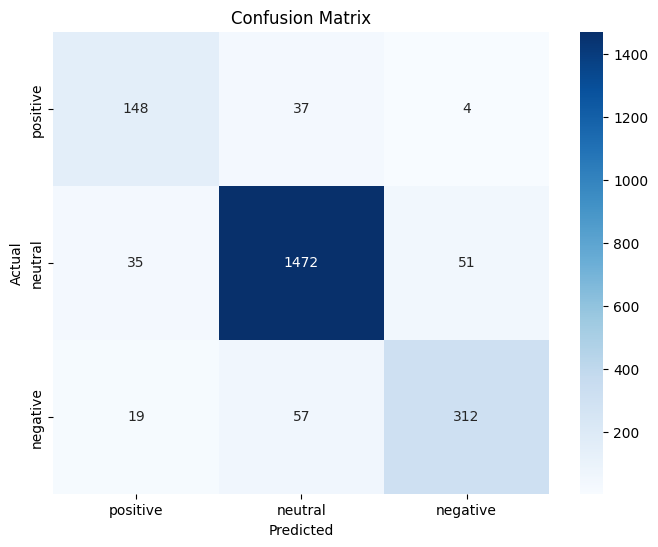

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

# Compute confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_path = "./indoRoBERTa-Finetuned"

trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('./indoRoBERTa-Finetuned/tokenizer_config.json',
 './indoRoBERTa-Finetuned/special_tokens_map.json',
 './indoRoBERTa-Finetuned/vocab.json',
 './indoRoBERTa-Finetuned/merges.txt',
 './indoRoBERTa-Finetuned/added_tokens.json',
 './indoRoBERTa-Finetuned/tokenizer.json')

In [ ]:
# !zip -r ./indoRoBERTa-Finetuned.zip ./indoRoBERTa-Finetuned


  adding: indoRoBERTa-Finetuned/ (stored 0%)
  adding: indoRoBERTa-Finetuned/special_tokens_map.json (deflated 85%)
  adding: indoRoBERTa-Finetuned/training_args.bin (deflated 52%)
  adding: indoRoBERTa-Finetuned/vocab.json (deflated 59%)
  adding: indoRoBERTa-Finetuned/model.safetensors (deflated 7%)
  adding: indoRoBERTa-Finetuned/tokenizer_config.json (deflated 75%)
  adding: indoRoBERTa-Finetuned/tokenizer.json (deflated 82%)
  adding: indoRoBERTa-Finetuned/merges.txt (deflated 54%)
  adding: indoRoBERTa-Finetuned/config.json (deflated 52%)


In [ ]:
from google.colab import files
files.download('./indoRoBERTa-Finetuned.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r ./wandb.zip ./wandb

  adding: wandb/ (stored 0%)
  adding: wandb/run-20250617_175534-bmz9agtj/ (stored 0%)
  adding: wandb/run-20250617_175534-bmz9agtj/logs/ (stored 0%)
  adding: wandb/run-20250617_175534-bmz9agtj/logs/debug-internal.log (deflated 86%)
  adding: wandb/run-20250617_175534-bmz9agtj/logs/debug-core.log (deflated 57%)
  adding: wandb/run-20250617_175534-bmz9agtj/logs/debug.log (deflated 87%)
  adding: wandb/run-20250617_175534-bmz9agtj/files/ (stored 0%)
  adding: wandb/run-20250617_175534-bmz9agtj/files/output.log (deflated 75%)
  adding: wandb/run-20250617_175534-bmz9agtj/files/requirements.txt (deflated 56%)
  adding: wandb/run-20250617_175534-bmz9agtj/files/wandb-metadata.json (deflated 42%)
  adding: wandb/run-20250617_175534-bmz9agtj/tmp/ (stored 0%)
  adding: wandb/run-20250617_175534-bmz9agtj/tmp/code/ (stored 0%)
  adding: wandb/run-20250617_175534-bmz9agtj/run-bmz9agtj.wandb (deflated 84%)
  adding: wandb/debug-internal.log (deflated 86%)
  adding: wandb/debug.log (deflated 87%)
  

In [ ]:
files.download('./wandb.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_path = "./indoRoBERTa-Finetuned"  # ganti sesuai nama folder hasil save_model

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # penting saat inference


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()

    label_map = {
        0: "Positive",
        1: "Neutral",
        2: "Negative"
    }

    # Ubah ke dict dengan pembulatan 2 desimal
    probs_dict = {
        label_map[i]: round(float(prob), 3)
        for i, prob in enumerate(probs.cpu().numpy()[0])
    }

    return {
        "text": text,
        "predicted_label": label_map[pred_label],
        "probabilities": probs_dict
    }


In [ ]:
print(predict_sentiment("Aplikasi ini sangat berguna dan saya suka sekali!"))
print(predict_sentiment("Biasa aja sih, tidak terlalu menarik"))
print(predict_sentiment("Saya kecewa, aplikasinya sering error"))


{'text': 'Aplikasi ini sangat berguna dan saya suka sekali!', 'predicted_label': 'Positive', 'probabilities': {'Positive': 0.999, 'Neutral': 0.001, 'Negative': 0.0}}
{'text': 'Biasa aja sih, tidak terlalu menarik', 'predicted_label': 'Negative', 'probabilities': {'Positive': 0.0, 'Neutral': 0.0, 'Negative': 0.999}}
{'text': 'Saya kecewa, aplikasinya sering error', 'predicted_label': 'Negative', 'probabilities': {'Positive': 0.0, 'Neutral': 0.0, 'Negative': 0.999}}


In [ ]:
texts = [
    "Desainnya menarik dan mudah digunakan.",
    "Pelayanannya sangat lambat.",
    "Oke sih, sesuai ekspektasi.",
]

for t in texts:
    print(predict_sentiment(t))


{'text': 'Desainnya menarik dan mudah digunakan.', 'predicted_label': 'Positive', 'probabilities': {'Positive': 0.999, 'Neutral': 0.001, 'Negative': 0.0}}
{'text': 'Pelayanannya sangat lambat.', 'predicted_label': 'Negative', 'probabilities': {'Positive': 0.0, 'Neutral': 0.0, 'Negative': 0.999}}
{'text': 'Oke sih, sesuai ekspektasi.', 'predicted_label': 'Neutral', 'probabilities': {'Positive': 0.011, 'Neutral': 0.609, 'Negative': 0.379}}
